In [15]:
# Key imports
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
# print(tf.__version__)
import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_VISIBLE_DEVICES']='0'

# tf 1.13
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
config = tf.ConfigProto(gpu_options=gpu_options)
# config.gpu_options.per_process_gpu_momory_fraction=0.7
# config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# tf 2.0
# gpu = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[0], True)
# gpu = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpu[1], True)

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = "logs2-full"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


In [16]:
%pip install quick-csv==0.0.6a0

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [17]:

# Config Key Parameters
import os
from quickcsv.file import *

DIM = 128  # image size DIMxDIM
EPOCHS = 500
CURRENT_MODEL_PATH = os.path.join(MODEL_DIR,f'mask_rcnn_infrared2_{DIM}_{EPOCHS}.h5')

root_path=fr'G:\UIBE科研\红外成像\InfraData\datasets-thermal-face\thermal_{DIM}'
dataset_path=fr'G:\UIBE科研\红外成像\InfraData\datasets-thermal-face\list_face_detection_{DIM}_merged.csv'

list_item=read_csv(dataset_path)
print('No. images: ',len(list_item))


Read CSV: ['name', 'masks', 'labels']  <- (G:\UIBE科研\红外成像\InfraData\datasets-thermal-face\list_face_detection_128_merged.csv)
No. images:  2935


In [18]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [19]:
#  model configuration 
class Infrared2Config(Config):
    """Configuration for training on the toy infrared dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "infrared"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 9  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape. Default = 128
    IMAGE_MIN_DIM = DIM
    IMAGE_MAX_DIM = DIM

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs. 32
    TRAIN_ROIS_PER_IMAGE = 5

    # Use a small epoch since the data is simple, Default =100
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    
config = Infrared2Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'bdry_score_loss': 1.0}
MASK_POOL_SIZE                 14

In [20]:
class InferenceConfig(Infrared2Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR,"logs/shapes20230601T0200/mask_rcnn_shapes_0002.h5")
# model_path = model.find_last()
model_path=CURRENT_MODEL_PATH

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  logs2-full\mask_rcnn_infrared2_128_500.h5


In [21]:

class Infrared2Dataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    
    def load_dataset(self,list_item,start,end):
        
        self.list_item=list_item
        
        all_classes='chin|leyebrow|reyebrow|centernose|bottomnose|leye|reye|outermouth|innermouth'.split('|')
        
        
        # only one class
        for idx,c in enumerate(all_classes):
            self.add_class("infrared2", idx+1, c)
        
        # load properties
        total_count=0
        for idx,item in enumerate( list_item[start:end+1]):
            image_path=root_path+"/"+item['name']+'.png'
            # print(image_path)
            # print(item['name'])
            self.add_image("infrared2",image_id=idx,path=image_path,name=item['name'])
            total_count+=1
        # print(f"loaded {total_count}")
    
    def draw_shape(self, image, shape, shape_points,color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        

        points = np.array([shape_points], dtype=np.int32)
        cv2.fillPoly(image, points, 1)
        
        # cv2.rectangle(image, (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), color, -1)
        # cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), color, -1)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        if info["source"] == "infrared":
            info = self.image_info[image_id]
            return info
        else:
            super(self.__class__).image_reference(self, image_id)



    def load_mask(self, image_id):
        # print("image name: ",self.list_item[image_id]['name'])
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.list_item[image_id]
        
        shapes=info['labels'].split('|')
        
        shape_points=[]
        for points_str in info['masks'].split('|'):
            points_str1=points_str.split(';')
            points=[]
            for p in points_str1:
                x=int(p.split(',')[0])
                y=int(p.split(',')[1])
                points.append((x,y))
            shape_points.append(points)
    
        count = len(shapes)
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], count], dtype=np.uint8)
        for i, shape in enumerate(shapes):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, shape_points[i], 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)



In [22]:
# Training dataset
dataset_train = Infrared2Dataset()
dataset_train.load_dataset(list_item,0,1599)
dataset_train.prepare()

# Validation dataset
dataset_val = Infrared2Dataset()
dataset_val.load_dataset(list_item,1600,1999)
dataset_val.prepare()

print(len(dataset_train.image_ids))
print(len(dataset_val.image_ids))

1600
400


In [23]:
# Test on a random image

image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
'''
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))
'''

original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (9,)                  min:    1.00000  max:    9.00000  int32
gt_bbox                  shape: (9, 4)                min:   53.00000  max:  118.00000  int32
gt_mask                  shape: (128, 128, 9)         min:    0.00000  max:    1.00000  bool


'\nvisualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, \n                            dataset_train.class_names, figsize=(8, 8))\n'

In [24]:
# Define metrics for performance evaluation
import numpy as np

# get face overall identification score
def get_face_overall_score(class_ids,class_names,class_scores):
    class_info={}
    for idx,class_id in enumerate(class_ids):
        class_name=class_names[class_id-1]
        score=class_scores[class_id-1]
        if class_name in class_info:
            class_info[class_name].append(score)
        else:
            class_info[class_name]=[score]
    class_avg_scores={}
    sum_score=0
    for k in class_info:
        mean_score=np.mean(class_info[k])
        class_avg_scores[k]=round(mean_score,4)
        sum_score=mean_score
    
    avg_score=sum_score/len(list(class_info[k]))
    return avg_score

# get face parts' score as a dictioary to evaluate the performance of detecting face parts
def get_face_part_scores(class_ids,class_names,class_scores):
    class_info={}
    for idx,class_id in enumerate(class_ids):
        class_name=class_names[class_id-1]
        score=class_scores[class_id-1]
        if class_name in class_info:
            class_info[class_name].append(score)
        else:
            class_info[class_name]=[score]
    class_avg_scores={}

    for k in class_info:
        mean_score=np.mean(class_info[k])
        class_avg_scores[k]=round(mean_score,4)
        
    return class_avg_scores
# get duplication of face part detections
def get_face_part_duplication(class_ids,class_names,class_scores):
    class_info={}
    for idx,class_id in enumerate(class_ids):
        class_name=class_names[class_id-1]
        score=class_scores[class_id-1]
        if class_name in class_info:
            class_info[class_name].append(score)
        else:
            class_info[class_name]=[score]
    class_avg_scores={}

    for k in class_info:
        mean_score=len(class_info[k])
        class_avg_scores[k]=mean_score
        
    return class_avg_scores

def get_detection_accuracy(class_ids,class_names,class_scores,all_classes):
    class_info=get_face_part_scores(class_ids,class_names,class_scores)
    my_classes=list(class_info.keys())
    percent=len(my_classes)*1.0/len(all_classes)
    return round(percent,4)

def get_detection_redudancy(class_ids,class_names,class_scores,all_classes):
    class_info=get_face_part_scores(class_ids,class_names,class_scores)
    my_classes=list(class_info.keys())
    percent=(len(class_ids)-len(my_classes)) / len(all_classes)
    return percent

def calculate_overlap_area(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2

    # 计算x轴上的重叠宽度
    if x2 < x3 or x4 < x1:
        overlap_width = 0
    else:
        overlap_width = min(x2, x4) - max(x1, x3)

    # 计算y轴上的重叠高度
    if y2 < y3 or y4 < y1:
        overlap_height = 0
    else:
        overlap_height = min(y2, y4) - max(y1, y3)

    # 计算重叠面积
    overlap_area = overlap_width * overlap_height

    return overlap_area

def get_region_diff(class_ids,class_names,class_scores,regions):
    class_info={}
    for idx,class_id in enumerate(class_ids):
        class_name=class_names[class_id-1]
        region=regions[class_id-1]
        if class_name in class_info:
            class_info[class_name].append(region)
        else:
            class_info[class_name]=[region]
    avg_ov=0
    for k in class_info:
        rs=class_info[k]
        if len(rs)>=2:
            list_ov=[]
            for idx in range(0,len(rs)-1):
                rs1=rs[idx]
                rs2=rs[idx+1]
                ov=calculate_overlap_area(rs1,rs2)
                list_ov.append(ov)
            mean_ov=np.mean(ov)
            avg_ov+=mean_ov
    avg_ov=avg_ov/len(list(class_info.keys()))
    return avg_ov

        


196
gt_class_id [1 2 3 4 5 6 7 8 9]
gt_bbox [[47 44 74 87]
 [35 46 42 55]
 [33 59 38 74]
 [39 52 44 58]
 [49 49 51 62]
 [41 48 44 54]
 [38 63 41 70]
 [56 49 62 63]
 [58 49 60 62]]
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  134.20000  float64
image_metas              shape: (1, 22)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


['chin', 'reye', 'bottomnose', 'outermouth', 'centernose', 'leye', 'reyebrow', 'bottomnose', 'leyebrow', 'centernose']
[1 7 5 8 4 6 3 5 2 4]
[0.03559553 0.10417931 0.02696307 0.07172215 0.07220887 0.05797374
 0.12798183 0.02064587 0.12666443 0.0522728 ]
10 10
chin 0.035595525
reye 0.10417931
bottomnose 0.026963072
outermouth 0.07172215
centernose 0.072208874
leye 0.057973735
reyebrow 0.12798183
bottomnose 0.020645866
leyebrow 0.12666443
centernose 0.052272797
[[53 40 98 90]
 [47 75 53 86]
 [64 62 67 75]
 [74 57 86 80]
 [48 67 67 69]
 [46 49 52 63]
 [39 73 47 90]
 [65 61 69 76]
 [40 44 47 67]
 [48 69 65 72]]
Overall score:  0.10417930781841278
Face duplication:  {'chin': 1, 'reyebrow': 1, 'centernose': 2, 'bottomnose': 2, 'outermouth': 2, 'leye': 1, 'reye': 1}
Face part scores:  {'chin': 0.0356, 'reyebrow': 0.128, 'centernose': 0.0722, 'bottomnose': 0.0238, 'outermouth': 0.0717, 'leye': 0.058, 'reye': 0.1042}
Face detection rate:  0.7
Face redundancy rate:  0.3
Overlap area:  48.5714285

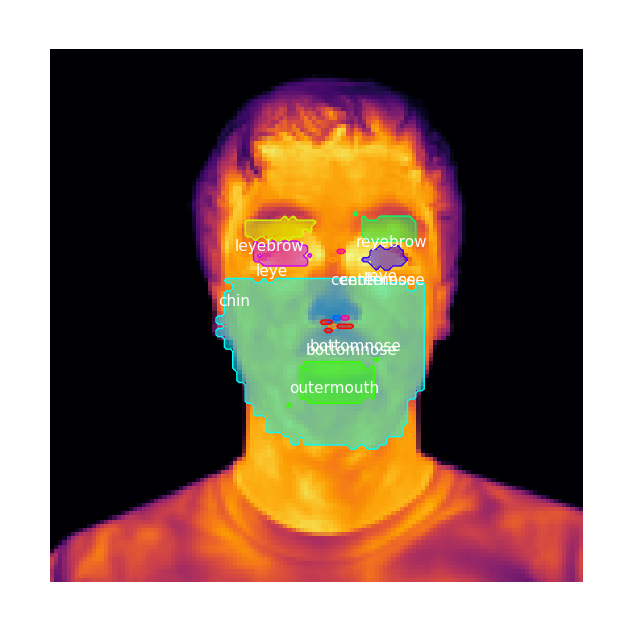

In [25]:
# test an example

# get a picture
image_id = random.choice(dataset_val.image_ids)
print(image_id)
# load picture
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
# print key info
# print("original_image", original_image)
# print("image_meta", image_meta)
print("gt_class_id", gt_class_id)
print("gt_bbox", gt_bbox)
# print("gt_mask", gt_mask)
# run the model
results = model.detect([original_image], verbose=1)

# show results
r = results[0]

print([dataset_val.class_names[idx] for idx in r['class_ids']])
print(r['class_ids'])
print(r['scores'])
print(len(r['class_ids']),len(r['scores']))

for idx, class_id in enumerate(r['class_ids']):
    print(dataset_val.class_names[class_id],r['scores'][idx])

print(r['rois'])
class_names=[dataset_val.class_names[idx] for idx in r['class_ids']]
overall_score=get_face_overall_score(r['class_ids'],class_names,r['scores'])
print("Overall score: ",overall_score)

print("Face duplication: ",get_face_part_duplication(r['class_ids'],class_names,r['scores']))
print("Face part scores: ",get_face_part_scores(r['class_ids'],class_names,r['scores']))
print("Face detection rate: ",get_detection_accuracy(r['class_ids'],class_names,r['scores'],dataset_val.class_names))
print("Face redundancy rate: ",get_detection_redudancy(r['class_ids'],class_names,r['scores'],dataset_val.class_names))
print("Overlap area: ",get_region_diff(r['class_ids'],class_names,r['scores'],r['rois']))



AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
print('AP: ',AP)
recall=utils.compute_recall(gt_bbox,r["rois"],iou=0.5)[0]
print('recall:',recall)
mean_precision=utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,r["rois"], r["class_ids"], r["scores"], r['masks'])
print("mean precision: ",mean_precision)

# display results
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, None, ax=get_ax(),show_bbox=False)

eval_model={
    "Overall score":get_face_part_duplication(r['class_ids'],class_names,r['scores']),
    "Face part scores":get_face_part_scores(r['class_ids'],class_names,r['scores']),
    "Face detection rate":get_detection_accuracy(r['class_ids'],class_names,r['scores'],dataset_val.class_names),
    "Face redundancy rate":get_detection_redudancy(r['class_ids'],class_names,r['scores'],dataset_val.class_names),
    "Overlap area":get_region_diff(r['class_ids'],class_names,r['scores'],r['rois']),
    "AP":AP,
    "recall":recall,
    "mean precision":mean_precision
}

print(eval_model)


In [26]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
Recalls=[]
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # metrics
    print('class no.:',len(r['class_ids']))
    # for idx, class_id in enumerate(r['class_ids']):
    #     print(dataset_val.class_names[class_id],r['scores'][idx])
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    recall=utils.compute_recall(gt_bbox,r["rois"],iou=0.5)[0]
    print('recall:',recall)
    Recalls.append(recall)
    mean_precision=utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,r["rois"], r["class_ids"], r["scores"], r['masks'])
    # print('mean precision:',mean_precision)
    APs.append(AP)
    
    # find matches
    gt_match, pred_match, overlaps, match_count=utils.compute_matches_revised(gt_bbox, gt_class_id, gt_mask,r["rois"], r["class_ids"], r["scores"], r['masks'])
    print('No. matches: ',match_count)
    
    # dice coef
    dice_coef=utils.compute_overlaps_masks(gt_mask, r['masks'])
    
    # print("dice coef:",dice_coef)
    
    print(AP, len(precisions),len(recalls))
    print(AP, precisions,recalls)
    print()
    
print("mAP: ", np.mean(APs), 'mRecall: ',np.mean(Recalls))

class no.: 10
recall: 0.0
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000
No. matches:  0
0.0 12 12
0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

class no.: 8
recall: 0.0
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000
No. matches:  0
0.0 10 10
0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

class no.: 15
recall: 0.26666666666666666
AP @0.50:	 0.037
AP @0.55:	 0.037
AP @0.60:	 0.037
AP @0.65:	 0.009
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.012
No. matches:  2
0.03703703731298447 17 17
0.03703703731298447 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667


# Batch evaluation


In [27]:
# test an example
def get_metrics(image_id):
    # get a picture
    # image_id = random.choice(dataset_val.image_ids)
    # print(image_id)
    # load picture
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                            image_id, use_mini_mask=False)
    # print key info
    # print("original_image", original_image)
    # print("image_meta", image_meta)
    # print("gt_class_id", gt_class_id)
    # print("gt_bbox", gt_bbox)
    # print("gt_mask", gt_mask)
    # run the model
    results = model.detect([original_image], verbose=1)

    # show results
    r = results[0]
    '''
    print([dataset_val.class_names[idx] for idx in r['class_ids']])
    print(r['class_ids'])
    print(r['scores'])
    print(len(r['class_ids']),len(r['scores']))
    '''
    
    # for idx, class_id in enumerate(r['class_ids']):
    #    print(dataset_val.class_names[class_id],r['scores'][idx])

    # print(r['rois'])
    class_names=[dataset_val.class_names[idx] for idx in r['class_ids']]
    overall_score=get_face_overall_score(r['class_ids'],class_names,r['scores'])
    '''
    print("Overall score: ",overall_score)

    print("Face duplication: ",get_face_part_duplication(r['class_ids'],class_names,r['scores']))
    print("Face part scores: ",get_face_part_scores(r['class_ids'],class_names,r['scores']))
    print("Face detection rate: ",get_detection_accuracy(r['class_ids'],class_names,r['scores'],dataset_val.class_names))
    print("Face redundancy rate: ",get_detection_redudancy(r['class_ids'],class_names,r['scores'],dataset_val.class_names))
    print("Overlap area: ",get_region_diff(r['class_ids'],class_names,r['scores'],r['rois']))
    '''


    AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                            r["rois"], r["class_ids"], r["scores"], r['masks'])
    # print('AP: ',AP)
    recall=utils.compute_recall(gt_bbox,r["rois"],iou=0.5)[0]
    # print('recall:',recall)
    mean_precision=utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,r["rois"], r["class_ids"], r["scores"], r['masks'])
    # print("mean precision: ",mean_precision)

    # display results
    '''
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())
    '''
    eval_model={
        "Overall score":get_face_overall_score(r['class_ids'],class_names,r['scores']),
        "Face part scores":get_face_part_scores(r['class_ids'],class_names,r['scores']),
        "Face detection rate":get_detection_accuracy(r['class_ids'],class_names,r['scores'],dataset_val.class_names),
        "Face redundancy rate":get_detection_redudancy(r['class_ids'],class_names,r['scores'],dataset_val.class_names),
        "Overlap area":get_region_diff(r['class_ids'],class_names,r['scores'],r['rois']),
        "AP":AP,
        "recall":recall,
        "mean precision":mean_precision
    }

    # print(eval_model)
    return eval_model

In [28]:
from quickcsv.file import *
import os

DIM=128

root_path=fr'G:\UIBE科研\红外成像\InfraData\datasets-thermal-face\thermal_{DIM}'

dataset_path=fr'G:\UIBE科研\红外成像\InfraData\datasets-thermal-face\list_face_detection_{DIM}_merged.csv'

list_item=read_csv(dataset_path)
print('No. images: ',len(list_item))

TRAIN_SIZE = int(len(list_item)*0.8)
VAL_SIZE=int(len(list_item)*0.2)

# Training dataset
dataset_train = Infrared2Dataset()
dataset_train.load_dataset(list_item,0,TRAIN_SIZE-1)
dataset_train.prepare()

# Validation dataset
dataset_val = Infrared2Dataset()
dataset_val.load_dataset(list_item,TRAIN_SIZE,2935-1)
dataset_val.prepare()

print(len(dataset_train.image_ids))
print(len(dataset_val.image_ids))

list_model=[]
for image_id in dataset_val.image_ids:
    try:
        eval_model=get_metrics(image_id)
    except:
        eval_model=None
    if eval_model!=None:
        eval_model['image_id']=image_id
        print(eval_model)
        list_model.append(eval_model)

write_csv(f'evals2/eval_{DIM}_{EPOCHS}.csv',list_model)


Read CSV: ['name', 'masks', 'labels']  <- (G:\UIBE科研\红外成像\InfraData\datasets-thermal-face\list_face_detection_128_merged.csv)
No. images:  2935
2348
587
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  131.20000  float64
image_metas              shape: (1, 22)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000
{'Overall score': 0.10243959724903107, 'Face part scores': {'chin': 0.0278, 'leyebrow': 0.1424, 'bottomnose': 0.0335, 'reyebrow': 0.0863, 'leye': 0.052, 'outermouth': 0.1024}, 'Face detection rate': 0.6, 'Face redundancy rate': 0.2, 'Overlap area': 10.666